Removed no burn in
Removed no burn in
Removed no burn in


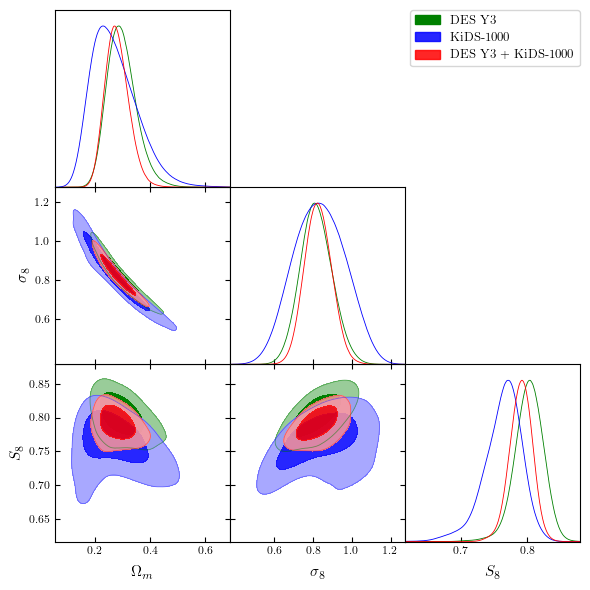

In [ ]:
import numpy as np
import matplotlib
from getdist import MCSamples, plots

matplotlib.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
})

def load_chain_with_weights(filename):
    data = np.loadtxt(filename)
    if filename == 'chain_desy3_hybrid_analysis.txt':
        samples = [data[:, 20], data[:, 18],data[:, 17]] # omegam, sigma8, S8
        weights = data[:, 31]
    elif filename == 'chain_kids1000_hybrid_analysis.txt':
        samples = [data[:, 17], data[:, 15],data[:, 14]] # omegam, sigma8, S8
        weights = data[:, 33]
    elif filename == 'chain_desy3_and_kids1000_hybrid_analysis.txt':
        samples = [data[:, 27], data[:, 25],data[:, 24]] # omegam, sigma8, S8
        weights = data[:, 50]
    return samples, weights

samples_des_arr, weights_des = load_chain_with_weights('chain_desy3_hybrid_analysis.txt')
samples_kids_arr, weights_kids = load_chain_with_weights('chain_kids1000_hybrid_analysis.txt')
samples_joint_arr, weights_joint = load_chain_with_weights('chain_desy3_and_kids1000_hybrid_analysis.txt')

names = ['omegam', 'sigma8', 'S_8']
labels = [r'\Omega_m', r'\sigma_8', r'S_8']

samples_des = MCSamples(samples=samples_des_arr, weights=weights_des, names=names, labels=labels, label='DES Y3')
samples_kids = MCSamples(samples=samples_kids_arr, weights=weights_kids, names=names, labels=labels, label='KiDS-1000')
samples_joint = MCSamples(samples=samples_joint_arr, weights=weights_joint, names=names, labels=labels, label='DES Y3 + KiDS-1000')

g = plots.get_subplot_plotter()
g.triangle_plot([samples_des, samples_kids, samples_joint], ['omegam', 'sigma8', 'S_8'],
                filled=True, contour_colors=['green', 'blue', 'red'],
                legend_loc='upper right')

In [1]:
from classy import Class

param_ranges = {
    'omegam': (0.2, 0.4),
    'sigma8': (0.6, 1.0),
    'gamma': (0.4, 0.8),
}

N_samples = 500

def compute_chi2(omega_m, sigma_8, gamma):
    params = {
        'output': 'mPk',
        'h': 0.674,
        'omega_b': 0.0224,
        'omega_cdm': omega_m * 0.674**2 - 0.0224,  # approx omega_cdm
        'n_s': 0.965,
        'A_s': (sigma_8 / 0.83)**2 * 2.1e-9,  # approx A_s ~ sigma8^2
        'tau_reio': 0.06,
    }

    cosmo = Class()
    cosmo.set(params)
    cosmo.compute()
    
    rd = cosmo.rs_drag()
    
    z_bao = 0.85
    h0 = 0.674
    c = 299792.458
    
    DM = cosmo.angular_distance(z_bao) * (1 + z_bao)  # DA -> DM
    
    dmrd_model = DM / rd
    
    # Hypothèse chi² simplifié : proche valeur standard + penalisation gamma arbitraire
    chi2 = ((dmrd_model - 20.38) / 0.5)**2 + ((gamma - 0.55)/0.1)**2
    
    cosmo.struct_cleanup()
    cosmo.empty()
    
    return chi2, dmrd_model, rd

samples = []
for _ in range(N_samples):
    omegam = np.random.uniform(*param_ranges['omegam'])
    sigma8 = np.random.uniform(*param_ranges['sigma8'])
    gamma = np.random.uniform(*param_ranges['gamma'])
    chi2_val, dmrd, rd_val = compute_chi2(omegam, sigma8, gamma)
    weight = 1.0
    
    samples.append([omegam, sigma8, gamma, dmrd, rd_val, chi2_val, weight])

samples = np.array(samples)

header = ("# omegam sigma8 gamma dmrd rd chi2 weight\n")

np.savetxt("chain_custom_simple.txt", samples, header=header, fmt="%1.6e")


Fichier 'chain_custom_simple.txt' généré avec 500 samples.


Removed no burn in


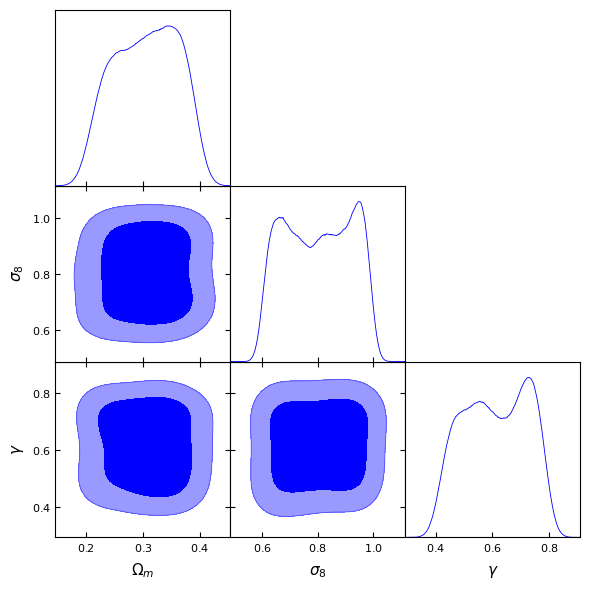

In [ ]:
import matplotlib.pyplot as plt

id_col_omegam = 0
id_col_sigma8 = 1
id_col_gamma = 2

def load_chain_custom(filename):
    data = np.loadtxt(filename, comments='#')
    samples = data[:, [id_col_omegam, id_col_sigma8, id_col_gamma]]
    weights = data[:, 6]
    return samples, weights

samples_arr, weights_arr = load_chain_custom('chain_custom_simple.txt')

names = ['omegam', 'sigma8', 'gamma']
labels = [r'\Omega_m', r'\sigma_8', r'\gamma']
samples = MCSamples(samples=samples_arr, weights=weights_arr,
                    names=names, labels=labels, label='Custom Chain')

g = plots.get_subplot_plotter()
g.triangle_plot([samples], ['omegam', 'sigma8', 'gamma'],
                filled=True, contour_colors=['blue'])
plt.show()
